In [1]:
import sys
!pip install -q sktime
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)


def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def SMAPE(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def get_train2():
    info = pd.read_csv('/kaggle/input/big-one/building_info.csv').drop(['태양광용량(kW)','ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1)
    info.columns = ['building', 'type', 'all_area', 'cool_area']
    types = info['type'].unique()
    value_dict = {value: index for index, value in enumerate(types)}
    info['type'] = info['type'].map(value_dict)

    info.loc[64, 'cool_area'] = 146585.0
    info.loc[65, 'cool_area'] = 83781.0
    info.loc[67, 'cool_area'] = 310488.0
    info.loc[76, 'cool_area'] = 35716.0
    info.loc[79, 'cool_area'] = 135899.6

    np.random.seed(0)

    cols = ['num_date_time', 'building', 'date_time', 'temp', 'prec','wind', 'hum', 'target']

    train = pd.read_csv('/kaggle/input/big-one/train.csv').drop(['일조(hr)', '일사(MJ/m2)'], axis=1)

    train['풍속(m/s)'] = train['풍속(m/s)'].fillna(method='ffill')
    train['습도(%)'] = train['습도(%)'].fillna(method='ffill')
    train = train.fillna(0)
    train.columns = cols
    train = train.merge(info, on='building', how='left')

    test = pd.read_csv('/kaggle/input/big-one/test.csv')
    test.columns = cols[:-1]
    test = test.merge(info, on='building', how='left')

    def add_data(df):
        for i in range(2):
            np.random.seed(i)
            num_rows = len(df)

            random_temp = df['temp'] * np.random.uniform(0.9, 1.1, num_rows)
            random_prec = df['prec'] * np.random.uniform(0.9, 1.1, num_rows)
            random_wind = df['wind'] * np.random.uniform(0.9, 1.1, num_rows)
            random_hum = df['hum'] * np.random.uniform(0.9, 1.1, num_rows)

            # 소수 첫째 자리까지 반올림
            random_temp = np.round(random_temp, 1)
            random_prec = np.round(random_prec, 1)
            random_wind = np.round(random_wind, 1)
            random_hum = np.round(random_hum, 1)

            # 새로운 데이터프레임 생성

            new_df = df.copy()
            new_df['temp'] = random_temp
            new_df['prec'] = random_prec
            new_df['wind'] = random_wind
            new_df['hum'] = random_hum

            # 기존 데이터프레임과 새로운 데이터프레임을 이어붙임
            df = pd.concat([df, new_df], ignore_index=True)
        df = df.sort_values(by=['building', 'date_time']).reset_index(drop=True)
        return df


    # 시간 관련 변수들 생성
    date = pd.to_datetime(train.date_time)
    train['hour'] = date.dt.hour
    train['dow'] = date.dt.weekday
    train['month'] = date.dt.month
    train['week'] = date.dt.isocalendar().week
    train['day'] = date.dt.day

    avg_temp = pd.pivot_table(train[train['hour']%3 == 0], values = 'temp', index = ['building', 'day'], aggfunc = np.mean).reset_index()
    avg_temp.rename(columns={'temp': 'avg_temp'}, inplace=True)
    train = pd.merge(train, avg_temp, on=['building', 'day'], how='left')

    date = pd.to_datetime(test.date_time)
    test['hour'] = date.dt.hour
    test['dow'] = date.dt.weekday
    test['month'] = date.dt.month
    test['week'] = date.dt.isocalendar().week
    test['day'] = date.dt.day

    avg_temp = pd.pivot_table(test[test['hour']%3 == 0], values = 'temp', index = ['building', 'day'], aggfunc = np.mean).reset_index()
    avg_temp.rename(columns={'temp': 'avg_temp'}, inplace=True)
    test = pd.merge(test, avg_temp, on=['building', 'day'], how='left')

    power_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'dow'], aggfunc = np.mean).reset_index()
    power_mean.rename(columns={'target': 'dow_hour_mean'}, inplace=True)
    train = pd.merge(train, power_mean, on=['building', 'hour', 'dow'], how='left')
    test = pd.merge(test, power_mean, on=['building', 'hour', 'dow'], how='left')

#     power_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'dow'], aggfunc = np.std).reset_index()
#     power_std.rename(columns={'target': 'dow_hour_std'}, inplace=True)
#     train = pd.merge(train, power_std, on=['building', 'hour', 'dow'], how='left')
#     test = pd.merge(test, power_std, on=['building', 'hour', 'dow'], how='left')

    # type_mean = pd.pivot_table(train, values = 'target', index = ['type', 'hour', 'dow'], aggfunc = np.mean).reset_index()
    # type_mean.rename(columns={'target': 'type_hour_mean'}, inplace=True)
    # train = pd.merge(train, type_mean, on=['type', 'hour', 'dow'], how='left')
    # test = pd.merge(test, type_mean, on=['type', 'hour', 'dow'], how='left')

    # type_std = pd.pivot_table(train, values = 'target', index = ['type', 'hour', 'dow'], aggfunc = np.std).reset_index()
    # type_std.rename(columns={'target': 'type_hour_std'}, inplace=True)
    # train = pd.merge(train, type_std, on=['type', 'hour', 'dow'], how='left')
    # test = pd.merge(test, type_std, on=['type', 'hour', 'dow'], how='left')

    ### 공휴일 변수 추가
    test['date'] = pd.to_datetime(test['date_time'], format='%Y-%m-%d %H')
    train['date'] = pd.to_datetime(train['date_time'], format='%Y-%m-%d %H')

    train['holiday'] = train.apply(lambda x : 0 if x['dow'] < 5 else 1, axis = 1)
    test['holiday'] = test.apply(lambda x : 0 if x['dow'] < 5 else 1, axis = 1)

    train.loc[train['building'] == 3, 'holiday'] = 0
    train.loc[(train['building'] == 3) & (train['dow'] == 0) , 'holiday'] = 1
    train.loc[(train['building'] == 3) & (train['date_time'].str.match(r'^20220731 \d{2}$')) , 'holiday'] = 1
    train.loc[(train['building'] == 3) & (train['date_time'].str.match(r'^20220723 \d{2}$')) , 'holiday'] = 1
    train.loc[(train['building'] == 3) & (train['date_time'].str.match(r'^20220720 \d{2}$')) , 'holiday'] = 1
    test.loc[test['building'] == 3, 'holiday'] = 0
    test.loc[(test['building'] == 3) & (test['dow'] == 0) , 'holiday'] = 1

    train.loc[train['building'] == 2, 'holiday'] = 0
    train.loc[(train['building'] == 2) & (train['dow'] == 0) , 'holiday'] = 1
    train.loc[(train['building'] == 2) & (train['date_time'].str.match(r'^20220607 \d{2}$')) , 'holiday'] = 1
    train.loc[(train['building'] == 2) & (train['date_time'].str.match(r'^20220617 \d{2}$')) , 'holiday'] = 1
    test.loc[test['building'] == 2, 'holiday'] = 0
    test.loc[(test['building'] == 2) & (test['dow'] == 0) , 'holiday'] = 1

    train.loc[train['building'] == 54, 'holiday'] = 0
    train.loc[(train['building'] == 54) & (train['dow'] == 0) , 'holiday'] = 1
    train.loc[(train['building'] == 54) & (train['date_time'].str.match(r'^20220816 \d{2}$')) , 'holiday'] = 1
    train.loc[(train['building'] == 54) & (train['date_time'].str.match(r'^20220817 \d{2}$')) , 'holiday'] = 1
    test.loc[test['building'] == 54, 'holiday'] = 0
    test.loc[(test['building'] == 54) & (test['dow'] == 0) , 'holiday'] = 1

    train.loc[(train['date_time'].str.match(r'^20220601 \d{2}$')) & (train['building'] != 14) , 'holiday'] = 1
    train.loc[(train['date_time'].str.match(r'^20220606 \d{2}$')) & (train['building'] != 14), 'holiday'] = 1
    train.loc[(train['date_time'].str.match(r'^20220815 \d{2}$')) & (train['building'] != 14), 'holiday'] = 1
    train.loc[(train['building'] == 14) & (train['date_time'].str.match(r'^20220614 \d{2}$')) , 'holiday'] = 1

    def week_of_month(date):
        first_day = date.replace(day=1)
        if (date.week - first_day.week + 1) % 2 == 0:
            if date.weekday() == 6:
                return 1
        return 0

    train['week_of_month'] = train['date'].apply(week_of_month)
    test['week_of_month'] = test['date'].apply(week_of_month)

    target_buildings = [87,88,89,90,91,92]
    train.loc[(train['building'].isin(target_buildings)) , 'holiday'] = 0
    train.loc[(train['building'].isin(target_buildings)) & (train['week_of_month'] == 1), 'holiday'] = 1
    test.loc[(test['building'].isin(target_buildings)) , 'holiday'] = 0
    test.loc[(test['building'].isin(target_buildings)) & (test['week_of_month'] == 1), 'holiday'] = 1

    train.loc[train['building'] == 85, 'holiday'] = 0
    test.loc[test['building'] == 85, 'holiday'] = 0

    test['date'] = pd.to_datetime(test['date_time'], format='%Y-%m-%d %H').dt.date
    train['date'] = pd.to_datetime(train['date_time'], format='%Y-%m-%d %H').dt.date

    target_day = ['2022-06-10', '2022-08-10', '2022-07-10', '2022-07-24', '2022-06-26', '2022-07-30']
    train.loc[train['building'] == 86, 'holiday'] = 0
    test.loc[test['building'] == 86, 'holiday'] = 0
    for i in target_day:
        k = pd.to_datetime(i)
        train.loc[(train['date'] == k.date()) & (train['building'] == 86), 'holiday'] = 1
        test.loc[(test['date'] == k.date()) & (train['building'] == 86), 'holiday'] = 1

    power_holiday_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'holiday'], aggfunc = np.mean).reset_index()
    power_holiday_mean.rename(columns={'target': 'holiday_mean'}, inplace=True)
    train = pd.merge(train, power_holiday_mean, on=['building', 'hour', 'holiday'], how='left')
    test = pd.merge(test, power_holiday_mean, on=['building', 'hour', 'holiday'], how='left')

    power_holiday_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'holiday'], aggfunc = np.std).reset_index()
    power_holiday_std.rename(columns={'target': 'holiday_std'}, inplace=True)
    train = pd.merge(train, power_holiday_std, on=['building', 'hour', 'holiday'], how='left')
    test = pd.merge(test, power_holiday_std, on=['building', 'hour', 'holiday'], how='left')

    power_hour_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour',], aggfunc = np.mean).reset_index()
    power_hour_mean.rename(columns={'target': 'hour_mean'}, inplace=True)
    train = pd.merge(train, power_hour_mean, on=['building', 'hour', ], how='left')
    test = pd.merge(test, power_hour_mean, on=['building', 'hour', ], how='left')

    power_hour_std = pd.pivot_table(train, values = 'target', index = ['building', 'hour',], aggfunc = np.std).reset_index()
    power_hour_std.rename(columns={'target': 'hour_std'}, inplace=True)
    train = pd.merge(train, power_hour_std, on=['building', 'hour', ], how='left')
    test = pd.merge(test, power_hour_std, on=['building', 'hour', ], how='left')

    # train = add_data(train)
    # valid = add_data(valid)

    ## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
    train['sin_time'] = np.sin(2*np.pi*train.hour/24)
    train['cos_time'] = np.cos(2*np.pi*train.hour/24)
    test['sin_time'] = np.sin(2*np.pi*test.hour/24)
    test['cos_time'] = np.cos(2*np.pi*test.hour/24)

    train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32
    #train['THI']=pd.cut(train.THI, bins=[-100, 68, 75, 80, 200], labels=['0', '1', '2', '3'])
    test['THI'] = 9/5*test['temp'] - 0.55*(1-test['hum']/100)*(9/5*test['hum']-26)+32
    #test['THI']=pd.cut(test.THI, bins=[-100, 68, 75, 80, 200], labels=['0', '1', '2', '3'])

    train['WC']=13.12+0.6215*train['temp']-13.947*train['wind']**0.16+0.486*train['temp']*train['wind']**0.16
    #train['WC']=pd.cut(train.WC, bins=[-100, 21, 25, 28, 31, 100], labels=[0,1,2,3,4])
    test['WC']=13.12+0.6215*test['temp']-13.947*test['wind']**0.16+0.486*test['temp']*test['wind']**0.16
    #test['WC']=pd.cut(test.WC, bins=[-100, 21, 25, 28, 31, 100], labels=[0,1,2,3,4])

    def CDH(xs):
        ys = []
        for i in range(len(xs)):
            if i < 11:
                ys.append(np.sum(xs[:(i+1)]-26))
            else:
                ys.append(np.sum(xs[(i-11):(i+1)]-26))
        return np.array(ys)

    cdhs = np.array([])
    for num in range(1,101):
        temp = train[train['building'] == num]
        cdh = CDH(temp['temp'].values)
        cdhs = np.concatenate([cdhs, cdh])
    train['CDH'] = cdhs

    cdhs = np.array([])
    for num in range(1,101):
        temp = test[test['building'] == num]
        cdh = CDH(temp['temp'].values)
        cdhs = np.concatenate([cdhs, cdh])
    test['CDH'] = cdhs

#     train['THI'] = train['THI'].astype('int')
#     train['WC'] = train['WC'].astype('int')
#     test['THI'] = test['THI'].astype('int')
#     test['WC'] = test['WC'].astype('int')
    train['week'] = train['week'].astype(np.int32)
    test['week'] = test['week'].astype(np.int32)

    def new_type(i):
        if i in [1,2,3,8,9,11,12,13,14,15]: return 0
        elif i in [17,18,19,20,21,22,23]: return 1
        elif i in [24,25,26,27,28,29,30,31]: return 2
        elif i in [32,33,34,35,36]: return 3
        elif i in [37,38,39,40,41,42,43,44]: return 4
        elif i in [45,46,47,48,49,50,51,52]: return 5
        elif i in [55,56,57,58]: return 6
        elif i in [53,54,59,60]: return 7
        elif i in [61,62,63,64,65,66,67,68]: return 8
        elif i in [69,70,71,72,73,74,75,76]: return 9
        elif i in [77,78,79,80,81,82,83,84]: return 10
        elif i in [87,88,89,90,91,92]: return 11
        elif i in [93,95,97,98,99,100]: return 12
        else: return 13

    train['new_type'] = train['building'].apply(new_type)
    test['new_type'] = test['building'].apply(new_type)

    # 37 : 620 711 88 617
    # 38 : 613 725 81
    # 39 : 718 88
    # 40 : 718 620 617 88
    # 41 : 627 725 88
    # 42 : 613 822 711
    
    target_buildings = [37,38,39,40,41,42]
    train.loc[(train['building'].isin(target_buildings)) , 'holiday'] = 0
    test.loc[(test['building'].isin(target_buildings)) , 'holiday'] = 0
    train.loc[(train['building'] == 37) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-20', '2022-07-11', '2022-08-08', '2022-06-17']])), 'holiday'] = 1
    train.loc[(train['building'] == 38) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-13', '2022-07-25', '2022-08-01']])), 'holiday'] = 1
    train.loc[(train['building'] == 39) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-07-18', '2022-08-08']])), 'holiday'] = 1
    train.loc[(train['building'] == 40) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-20', '2022-07-18', '2022-06-17', '2022-08-08']])), 'holiday'] = 1
    train.loc[(train['building'] == 41) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-27', '2022-07-25', '2022-08-08']])), 'holiday'] = 1
    train.loc[(train['building'] == 42) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-13', '2022-07-11', '2022-08-22']])), 'holiday'] = 1
    
#     train.drop(train[(train['building'] == 37) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-20', '2022-07-11', '2022-08-08', '2022-06-17']]))].index, inplace=True)
#     train.drop(train[(train['building'] == 38) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-13', '2022-07-25', '2022-08-01',]]))].index, inplace=True)
#     train.drop(train[(train['building'] == 39) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-07-18', '2022-08-08',]]))].index, inplace=True)
#     train.drop(train[(train['building'] == 40) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-20', '2022-07-18', '2022-06-17', '2022-08-08']]))].index, inplace=True)
#     train.drop(train[(train['building'] == 41) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-27', '2022-07-25', '2022-08-08']]))].index, inplace=True)
#     train.drop(train[(train['building'] == 42) & (train['date'].isin([pd.to_datetime(i).date() for i in ['2022-06-13', '2022-07-11', '2022-08-22',]]))].index, inplace=True)

    train.drop(['hour', 'date', 'week_of_month', 'avg_temp', 'prec', 'type', 'new_type', 'cool_area', 'all_area', 'day'], axis = 1, inplace = True)
    test.drop(['hour', 'date', 'week_of_month', 'avg_temp', 'prec', 'type', 'new_type', 'cool_area', 'all_area', 'day'], axis = 1, inplace = True)

    print('done')
    return train, test
train, test = get_train2()

done


In [ ]:
import optuna
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

df = pd.DataFrame()
# 
for i in tqdm(range(100)):
    def objective(trial):
        y = train.loc[train.building == i+1, 'target']
        x = train.loc[train.building == i+1, ].iloc[:, 3:].drop(['target', ], axis=1)
        y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

        param = {
            # 'tree_method':'gpu_hist',  # Use GPU acceleration
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
            'gamma': trial.suggest_float('gamma', 0, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
            'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#            'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'weighted_mse100', 'weighted_mse7'])
        }
#         if param['objective'] == 'weighted_mse100':
#             model = XGBRegressor(n_estimators=100, learning_rate=0.1,
#                                 reg_lambda=param['reg_lambda'], gamma=param['gamma'],
#                                 reg_alpha=param['reg_alpha'],
#                                 colsample_bytree=param['colsample_bytree'], subsample=param['subsample'],
#                                 max_depth=param['max_depth'], min_child_weight=param['min_child_weight'],
#                                 objective=weighted_mse(100))
#         elif param['objective'] == 'weighted_mse7':
#             model = XGBRegressor(n_estimators=100, learning_rate=0.1,
#                                 reg_lambda=param['reg_lambda'], gamma=param['gamma'],
#                                 reg_alpha=param['reg_alpha'],
#                                 colsample_bytree=param['colsample_bytree'], subsample=param['subsample'],
#                                 max_depth=param['max_depth'], min_child_weight=param['min_child_weight'],
#                                 objective=weighted_mse(7))
#        else:
        model = XGBRegressor(**param, n_estimators=100, learning_rate=0.1)  

        model.fit(x_train,y_train, verbose=False)
        preds = model.predict(x_test)
        
        return SMAPE(y_test, preds)


    study = optuna.create_study(direction='minimize', study_name=None)
    study.optimize(objective, n_trials=100)
    df = pd.concat([df, study.trials_dataframe().sort_values(by=['value'], ascending=[True]).head(1)], ignore_index=True)

df.to_csv('parameters.csv', index=False)
df

 69%|██████▉   | 69/100 [22:55<11:05, 21.47s/it]

In [6]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(1,101)):
    y = train.loc[train.building == i, 'target']
    x = train.loc[train.building == i, ].iloc[:, 3:].drop(['target'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=6, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None, early_stopping_rounds=300)
    
    xgb_reg.set_params(**{'objective':weighted_mse(100)})
    
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], verbose=False)
    
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)   
    
    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration+1) ## 실제 best iteration은 이 값에 +1 해주어야 함.
print(sum(scores)/len(scores))

100%|██████████| 100/100 [06:53<00:00,  4.14s/it]

4.472399041330698


In [7]:
alpha_list = []
smape_list = []
xgb_params = pd.DataFrame()
for i in tqdm(range(100)):
    y = train.loc[train.building == i+1, 'target']
    x = train.loc[train.building == i+1, ].iloc[:, 3:].drop(['target'], axis=1)
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
         gpu_id=-1, importance_type='gain', interaction_constraints='',
         learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
         min_child_weight=6, monotone_constraints='()',
         n_estimators=best_it[i], n_jobs=0, num_parallel_tree=1,
         random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         seed=0, subsample=0.9, tree_method='exact', validate_parameters=1,
         verbosity=None,)

    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    best_alpha = 0
    score0 = SMAPE(y_test,pred0)
    
    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
                 gpu_id=-1, importance_type='gain', interaction_constraints='',
                 learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
                 min_child_weight=6, monotone_constraints='()',
                 n_estimators=10000, n_jobs=0, num_parallel_tree=1,
                 random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 seed=0, subsample=0.9, tree_method='exact', validate_parameters=1,
                 verbosity=None, early_stopping_rounds=300)

        xgb.set_params(**{'objective':weighted_mse(j)}) 

        xgb.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                                (x_valid, y_valid)], verbose=False)
        pred1 = xgb.predict(x_test)
        score1 = SMAPE(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1
    
    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print(f"building {i+1} || best score : {score0} || alpha : {best_alpha}")
    
xgb_params['alpha'] = alpha_list
xgb_params['best_it'] = best_it

xgb_params.head()

  1%|          | 1/100 [00:17<29:11, 17.69s/it]

building 1 || best score : 5.9840476933026 || alpha : 0


  2%|▏         | 2/100 [00:39<33:11, 20.32s/it]

building 2 || best score : 9.083105379428497 || alpha : 0


  3%|▎         | 3/100 [01:03<35:17, 21.83s/it]

building 3 || best score : 9.122044576576444 || alpha : 100


  4%|▍         | 4/100 [01:27<36:26, 22.78s/it]

building 4 || best score : 3.7220643337688957 || alpha : 0


  5%|▌         | 5/100 [01:44<32:40, 20.64s/it]

building 5 || best score : 7.509715010100307 || alpha : 0


  6%|▌         | 6/100 [02:06<33:12, 21.20s/it]

building 6 || best score : 4.381266565360323 || alpha : 0


  7%|▋         | 7/100 [02:49<43:36, 28.13s/it]

building 7 || best score : 7.835432425881558 || alpha : 0


  8%|▊         | 8/100 [03:10<39:33, 25.80s/it]

building 8 || best score : 5.304831799178455 || alpha : 0


  9%|▉         | 9/100 [03:28<35:37, 23.49s/it]

building 9 || best score : 3.0972792987717184 || alpha : 0


 10%|█         | 10/100 [03:43<31:29, 20.99s/it]

building 10 || best score : 6.371807495510394 || alpha : 0


 11%|█         | 11/100 [04:00<29:11, 19.68s/it]

building 11 || best score : 3.5368969276988786 || alpha : 0


 12%|█▏        | 12/100 [04:23<30:15, 20.63s/it]

building 12 || best score : 3.8550215524763862 || alpha : 0


 13%|█▎        | 13/100 [04:39<28:08, 19.41s/it]

building 13 || best score : 6.219704822545139 || alpha : 0


 14%|█▍        | 14/100 [04:59<27:49, 19.41s/it]

building 14 || best score : 16.04208755900228 || alpha : 0


 15%|█▌        | 15/100 [05:18<27:27, 19.39s/it]

building 15 || best score : 3.4164574725437 || alpha : 0


 16%|█▌        | 16/100 [05:36<26:38, 19.04s/it]

building 16 || best score : 4.160002837275592 || alpha : 0


 17%|█▋        | 17/100 [06:53<50:06, 36.22s/it]

building 17 || best score : 5.647393893262314 || alpha : 1


 18%|█▊        | 18/100 [07:15<43:54, 32.13s/it]

building 18 || best score : 6.800335942141665 || alpha : 0


 19%|█▉        | 19/100 [07:43<41:35, 30.81s/it]

building 19 || best score : 7.872283263374749 || alpha : 0


 20%|██        | 20/100 [08:07<38:15, 28.70s/it]

building 20 || best score : 3.929901706952447 || alpha : 0


 21%|██        | 21/100 [08:26<33:54, 25.76s/it]

building 21 || best score : 7.176220684198705 || alpha : 0


 22%|██▏       | 22/100 [08:49<32:31, 25.02s/it]

building 22 || best score : 3.6525337497466532 || alpha : 0


 23%|██▎       | 23/100 [09:09<30:06, 23.46s/it]

building 23 || best score : 1.4582964458237857 || alpha : 0


 24%|██▍       | 24/100 [09:24<26:40, 21.06s/it]

building 24 || best score : 2.3711824437520552 || alpha : 0


 25%|██▌       | 25/100 [09:39<23:59, 19.19s/it]

building 25 || best score : 2.1143685142485014 || alpha : 0


 26%|██▌       | 26/100 [09:55<22:33, 18.30s/it]

building 26 || best score : 2.187716231513539 || alpha : 0


 27%|██▋       | 27/100 [10:09<20:39, 16.98s/it]

building 27 || best score : 1.279496305728572 || alpha : 0


 28%|██▊       | 28/100 [10:29<21:28, 17.89s/it]

building 28 || best score : 4.0475526885961015 || alpha : 0


 29%|██▉       | 29/100 [10:49<21:45, 18.38s/it]

building 29 || best score : 3.6494177686008737 || alpha : 0


 30%|███       | 30/100 [11:19<25:32, 21.89s/it]

building 30 || best score : 7.1535656118386814 || alpha : 5


 31%|███       | 31/100 [11:41<25:16, 21.97s/it]

building 31 || best score : 4.2736800301162665 || alpha : 0


 32%|███▏      | 32/100 [11:54<21:56, 19.36s/it]

building 32 || best score : 0.4234495135903367 || alpha : 0


 33%|███▎      | 33/100 [12:09<19:57, 17.87s/it]

building 33 || best score : 0.31718940508563853 || alpha : 0


 34%|███▍      | 34/100 [12:23<18:34, 16.89s/it]

building 34 || best score : 0.7143829280743348 || alpha : 0


 35%|███▌      | 35/100 [12:41<18:33, 17.14s/it]

building 35 || best score : 0.5055309546006589 || alpha : 0


 36%|███▌      | 36/100 [12:55<17:25, 16.34s/it]

building 36 || best score : 0.37850131251392766 || alpha : 0


 37%|███▋      | 37/100 [13:17<18:49, 17.93s/it]

building 37 || best score : 3.7527021206748543 || alpha : 0


 38%|███▊      | 38/100 [13:48<22:42, 21.98s/it]

building 38 || best score : 3.5030792746610957 || alpha : 1


 39%|███▉      | 39/100 [14:20<25:21, 24.95s/it]

building 39 || best score : 3.7404985752779814 || alpha : 0


 40%|████      | 40/100 [14:45<24:49, 24.83s/it]

building 40 || best score : 8.646105555404532 || alpha : 0


 41%|████      | 41/100 [15:04<22:43, 23.11s/it]

building 41 || best score : 3.559335615883421 || alpha : 0


 42%|████▏     | 42/100 [15:40<26:02, 26.95s/it]

building 42 || best score : 4.653960556043931 || alpha : 3


 43%|████▎     | 43/100 [16:20<29:26, 30.99s/it]

building 43 || best score : 5.116832749821416 || alpha : 3


 44%|████▍     | 44/100 [16:48<27:51, 29.84s/it]

building 44 || best score : 3.292495673752131 || alpha : 0


 45%|████▌     | 45/100 [17:03<23:21, 25.49s/it]

building 45 || best score : 2.2842829781051344 || alpha : 0


 46%|████▌     | 46/100 [17:21<20:53, 23.20s/it]

building 46 || best score : 5.104885817682078 || alpha : 0


 47%|████▋     | 47/100 [17:35<18:07, 20.53s/it]

building 47 || best score : 4.285527450557575 || alpha : 0


 48%|████▊     | 48/100 [17:54<17:16, 19.92s/it]

building 48 || best score : 1.8556346529064331 || alpha : 0


 49%|████▉     | 49/100 [18:09<15:46, 18.56s/it]

building 49 || best score : 1.9810676915816998 || alpha : 0


 50%|█████     | 50/100 [18:25<14:57, 17.95s/it]

building 50 || best score : 2.0813397310618273 || alpha : 0


 51%|█████     | 51/100 [18:42<14:20, 17.55s/it]

building 51 || best score : 3.8714106362573046 || alpha : 0


 52%|█████▏    | 52/100 [19:01<14:20, 17.92s/it]

building 52 || best score : 3.272810066405589 || alpha : 0


 53%|█████▎    | 53/100 [19:21<14:31, 18.55s/it]

building 53 || best score : 13.448757989978214 || alpha : 0


 54%|█████▍    | 54/100 [19:55<17:44, 23.14s/it]

building 54 || best score : 14.802879855667117 || alpha : 3


 55%|█████▌    | 55/100 [20:16<16:59, 22.66s/it]

building 55 || best score : 1.5165204752269 || alpha : 0


 56%|█████▌    | 56/100 [20:31<14:58, 20.43s/it]

building 56 || best score : 0.6214672452072927 || alpha : 0


 57%|█████▋    | 57/100 [20:57<15:47, 22.03s/it]

building 57 || best score : 4.194817310085631 || alpha : 0


 58%|█████▊    | 58/100 [21:11<13:44, 19.63s/it]

building 58 || best score : 0.3820424858062876 || alpha : 0


 59%|█████▉    | 59/100 [21:43<15:51, 23.20s/it]

building 59 || best score : 4.3241988525156 || alpha : 0


 60%|██████    | 60/100 [22:00<14:17, 21.43s/it]

building 60 || best score : 5.366043505469759 || alpha : 0


 61%|██████    | 61/100 [22:16<12:50, 19.77s/it]

building 61 || best score : 3.716245378974095 || alpha : 0


 62%|██████▏   | 62/100 [22:41<13:31, 21.36s/it]

building 62 || best score : 4.354566021184845 || alpha : 0


 63%|██████▎   | 63/100 [23:26<17:27, 28.31s/it]

building 63 || best score : 4.563158245469306 || alpha : 1


 64%|██████▍   | 64/100 [23:48<15:52, 26.47s/it]

building 64 || best score : 3.5797106011186055 || alpha : 0


 65%|██████▌   | 65/100 [24:46<20:56, 35.89s/it]

building 65 || best score : 7.963406455428768 || alpha : 0


 66%|██████▌   | 66/100 [25:43<24:00, 42.36s/it]

building 66 || best score : 3.254839589080706 || alpha : 3


 67%|██████▋   | 67/100 [26:03<19:31, 35.51s/it]

building 67 || best score : 4.748448317779982 || alpha : 0


 68%|██████▊   | 68/100 [26:21<16:12, 30.40s/it]

building 68 || best score : 3.003958745755969 || alpha : 0


 69%|██████▉   | 69/100 [26:36<13:15, 25.67s/it]

building 69 || best score : 2.5529344591558445 || alpha : 0


 70%|███████   | 70/100 [26:52<11:22, 22.74s/it]

building 70 || best score : 2.33185286669241 || alpha : 0


 71%|███████   | 71/100 [27:09<10:12, 21.11s/it]

building 71 || best score : 3.7818429247576226 || alpha : 0


 72%|███████▏  | 72/100 [27:29<09:39, 20.71s/it]

building 72 || best score : 5.301845112285776 || alpha : 0


 73%|███████▎  | 73/100 [27:44<08:35, 19.08s/it]

building 73 || best score : 2.8384983186932446 || alpha : 0


 74%|███████▍  | 74/100 [27:59<07:45, 17.89s/it]

building 74 || best score : 5.037367162923875 || alpha : 0


 75%|███████▌  | 75/100 [28:19<07:45, 18.63s/it]

building 75 || best score : 5.074210832964962 || alpha : 0


 76%|███████▌  | 76/100 [28:40<07:40, 19.20s/it]

building 76 || best score : 4.847741672613207 || alpha : 0


 77%|███████▋  | 77/100 [29:01<07:36, 19.84s/it]

building 77 || best score : 2.414383486154715 || alpha : 0


 78%|███████▊  | 78/100 [29:24<07:32, 20.59s/it]

building 78 || best score : 3.4331495907975724 || alpha : 0


 79%|███████▉  | 79/100 [29:40<06:43, 19.23s/it]

building 79 || best score : 3.2700215880247927 || alpha : 0


 80%|████████  | 80/100 [30:00<06:30, 19.51s/it]

building 80 || best score : 3.3788182398953377 || alpha : 0


 81%|████████  | 81/100 [30:31<07:18, 23.10s/it]

building 81 || best score : 2.987949132211474 || alpha : 0


 82%|████████▏ | 82/100 [30:50<06:33, 21.84s/it]

building 82 || best score : 4.294488529168283 || alpha : 0


 83%|████████▎ | 83/100 [31:17<06:35, 23.26s/it]

building 83 || best score : 3.0040384075451803 || alpha : 0


 84%|████████▍ | 84/100 [31:39<06:08, 23.04s/it]

building 84 || best score : 2.781029349320103 || alpha : 0


 85%|████████▌ | 85/100 [31:57<05:20, 21.38s/it]

building 85 || best score : 3.128115643355869 || alpha : 0


 86%|████████▌ | 86/100 [32:25<05:26, 23.34s/it]

building 86 || best score : 4.092918087935603 || alpha : 0


 87%|████████▋ | 87/100 [32:47<05:00, 23.08s/it]

building 87 || best score : 7.62388435605372 || alpha : 0


 88%|████████▊ | 88/100 [33:17<05:02, 25.19s/it]

building 88 || best score : 3.0284221359748944 || alpha : 1


 89%|████████▉ | 89/100 [33:45<04:45, 25.94s/it]

building 89 || best score : 3.2617501686467336 || alpha : 0


 90%|█████████ | 90/100 [34:16<04:34, 27.45s/it]

building 90 || best score : 4.013366115651672 || alpha : 7


 91%|█████████ | 91/100 [34:58<04:45, 31.77s/it]

building 91 || best score : 10.834639253609286 || alpha : 1


 92%|█████████▏| 92/100 [35:37<04:32, 34.08s/it]

building 92 || best score : 3.440087476061091 || alpha : 1


 93%|█████████▎| 93/100 [36:04<03:42, 31.75s/it]

building 93 || best score : 6.2066751753431575 || alpha : 0


 94%|█████████▍| 94/100 [36:21<02:44, 27.47s/it]

building 94 || best score : 6.108287951252434 || alpha : 0


 95%|█████████▌| 95/100 [36:44<02:09, 25.99s/it]

building 95 || best score : 13.317026198043353 || alpha : 0


 96%|█████████▌| 96/100 [36:59<01:31, 22.81s/it]

building 96 || best score : 2.816158743531264 || alpha : 0


 97%|█████████▋| 97/100 [37:26<01:11, 23.90s/it]

building 97 || best score : 4.998493637714644 || alpha : 0


 98%|█████████▊| 98/100 [37:56<00:52, 26.02s/it]

building 98 || best score : 12.345406990706872 || alpha : 0


 99%|█████████▉| 99/100 [38:22<00:25, 25.80s/it]

building 99 || best score : 2.940478020710276 || alpha : 0


100%|██████████| 100/100 [38:57<00:00, 23.37s/it]

building 100 || best score : 4.851064779177453 || alpha : 50


,alpha,best_it
0,0,364
1,0,307
2,100,216
3,0,300
4,0,448


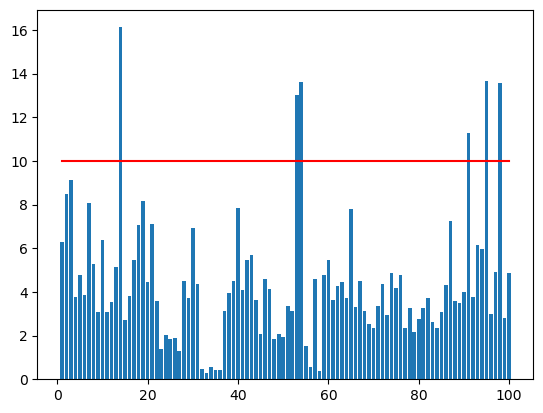

In [8]:
no_df = pd.DataFrame({'score':scores})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,100], [10, 10], color = 'red')

In [9]:
preds = np.array([]) 
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    
    for seed in [0,1,2,3,4]: # 각 시드별 예측
        y_train = train.loc[train.building == i+1, 'target']
        x_train, x_test = train.loc[train.building == i+1, ].iloc[:, 3:].drop(['target'], axis=1), test.loc[test.building == i+1, ].iloc[:,3:]
        x_test = x_test[x_train.columns]
        
        
        xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
                 gpu_id=-1, importance_type='gain', interaction_constraints='',
                 learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
                 min_child_weight=6, monotone_constraints='()',
                 n_estimators=best_it[i], n_jobs=0, num_parallel_tree=1,
                 random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 seed=seed, subsample=0.9, tree_method='exact', validate_parameters=1,
                 verbosity=None)
        
        if xgb_params.loc[i, 'alpha'] != 0:
            xgb.set_params(**{'objective':weighted_mse(xgb_params.loc[i, 'alpha'])})
        
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)   
    
submission = pd.read_csv('/kaggle/input/big-one/sample_submission.csv')
submission['answer'] = preds
submission.to_csv('./submission_xgb.csv', index = False)

100%|██████████| 100/100 [09:34<00:00,  5.74s/it]


In [10]:
submission

,num_date_time,answer
0,1_20220825 00,1963.044922
1,1_20220825 01,1853.935913
2,1_20220825 02,1696.383423
3,1_20220825 03,1631.057495
4,1_20220825 04,1637.963623
...,...,...
16795,100_20220831 19,918.836121
16796,100_20220831 20,873.771301
16797,100_20220831 21,787.078735
16798,100_20220831 22,644.956726
